# Recommandation de photos

Approche choisie pour créer un système de recommandation : Algorithme de clustering

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import json

Récupère les données des images favorites de l'utilisateur

In [20]:
# Charge les données du fichier JSON
with open("profil.json", "r", encoding="utf-8") as file:
    json_data = json.load(file)

# Extrait les données et les résultats
img_paths = json_data["images"]
data = json_data["data"]
result = json_data["resultats"]

# Crée le DataFrame
data_images = pd.DataFrame(img_paths, columns=["nom_image"])
# Ajoute les colonnes en décomposant les données de "data"
data_expanded = pd.DataFrame(data, columns=["orientation", "qualite", "animal", "nature", "luminosite"])
# Et concatène les deux DataFrames
dataframe = pd.concat([data_images, data_expanded], axis=1)

# Convertit le DataFrame en une liste
given_images = dataframe
given_images = given_images.values.tolist()

# Ajoute la colonne des résultats
dataframe['result'] = result

# Filtre les données pour ne garder que les images favorites
df_favorite = dataframe[dataframe['result'] == 'Favorite']

# Supprime la colonne 'result' après le filtrage
df_favorite = df_favorite.drop(columns=["result"])

# Convertit le DataFrame en une liste
favorite_list = df_favorite.values.tolist()

In [21]:
print("longueur :", len(df_favorite))
print(favorite_list)
print(df_favorite)

longueur : 9
[['94.jpg', 'Paysage', 'moyenne', 'Chien', 'pas de nature', 'lumineux'], ['109.jpg', 'Paysage', 'moyenne', 'Chat', 'pas de nature', 'lumineux'], ['40.jpg', 'Portrait', 'basse', 'Chien', 'pas de nature', 'lumineux'], ['104.jpg', 'Paysage', 'haute', 'Chien', 'en nature', 'sombre'], ['107.jpg', 'Portrait', 'moyenne', 'Chat', 'pas de nature', 'lumineux'], ['52.jpg', 'Paysage', 'moyenne', 'Chien', 'pas de nature', 'lumineux'], ['29.JPG', 'Portrait', 'haute', 'Chat', 'pas de nature', 'lumineux'], ['15.jpg', 'Portrait', 'moyenne', 'Chat', 'pas de nature', 'lumineux'], ['106.jpg', 'Portrait', 'basse', 'Chat', 'pas de nature', 'sombre']]
   nom_image orientation  qualite animal         nature luminosite
0     94.jpg     Paysage  moyenne  Chien  pas de nature   lumineux
5    109.jpg     Paysage  moyenne   Chat  pas de nature   lumineux
7     40.jpg    Portrait    basse  Chien  pas de nature   lumineux
13   104.jpg     Paysage    haute  Chien      en nature     sombre
14   107.jpg   

Récupère les données de toutes les images existantes et enlève les 20 images proposées à l'utilisateur

In [22]:
# Charge les données du fichier JSON
with open("etiquetage.json", "r", encoding="utf-8") as file:
    json_data = json.load(file)

# Crée le DataFrame
dataframe = pd.DataFrame(json_data, columns=["nom_image", "orientation", "qualite", "animal", "nature", "luminosite"])

# Filtrer les données pour exclure les images spécifiées
dataframe_filtered = dataframe[~dataframe["nom_image"].isin(img_paths)]

# Convertit le DataFrame en une liste
data_list = dataframe.values.tolist()
data_list_filtered = dataframe_filtered.values.tolist()

In [23]:
print("longueur :", len(data_list))
print(data_list)
print("longueur :", len(data_list_filtered))
print(data_list_filtered)
print(dataframe_filtered)
print(len(favorite_list))

longueur : 116
[['1.jpg', 'Paysage', 'moyenne', 'Chien', 'pas de nature', 'sombre'], ['10.jpg', 'Portrait', 'moyenne', 'Chat', 'en nature', 'lumineux'], ['100.jpg', 'Paysage', 'moyenne', 'Chien', 'pas de nature', 'lumineux'], ['101.png', 'Portrait', 'moyenne', 'Chat', 'pas de nature', 'sombre'], ['102.jpg', 'Paysage', 'haute', 'Chien', 'en nature', 'sombre'], ['103.jpg', 'Paysage', 'basse', 'Chien', 'pas de nature', 'lumineux'], ['104.jpg', 'Paysage', 'haute', 'Chien', 'en nature', 'sombre'], ['105.jpg', 'Paysage', 'moyenne', 'Chien', 'en nature', 'sombre'], ['106.jpg', 'Portrait', 'basse', 'Chat', 'pas de nature', 'sombre'], ['107.jpg', 'Portrait', 'moyenne', 'Chat', 'pas de nature', 'lumineux'], ['108.jpg', 'Paysage', 'moyenne', 'Chat', 'pas de nature', 'lumineux'], ['109.jpg', 'Paysage', 'moyenne', 'Chat', 'pas de nature', 'lumineux'], ['11.jpg', 'Paysage', 'moyenne', 'Chat', 'pas de nature', 'sombre'], ['110.jpg', 'Portrait', 'moyenne', 'Chat', 'pas de nature', 'lumineux'], ['111.j

In [24]:
def recommend_items(cluster, data_with_clusters, given_images):
    # Normalisation des noms d'images dans data_with_clusters
    data_with_clusters["nom_image"] = (
        data_with_clusters["nom_image"]
        .str.lower()
        .str.strip()
        .str.replace(r'\.jpeg$', '.jpeg', regex=True)
        .str.replace(r'\.jpg$', '.jpg', regex=True)
        .str.replace(r'\.png$', '.png', regex=True)
    )

    # Extraction et normalisation des noms dans given_image_names
    given_image_names = [
        img[0].lower().strip()
        .replace('.jpeg', '.jpeg')
        .replace('.jpg', '.jpg')
        .replace('.png', '.png')
        for img in given_images
    ]

    # Images uniques
    given_image_names = list(set(given_image_names))

    # Selections des items des clusters
    items_in_cluster = data_with_clusters[data_with_clusters["Cluster"] == cluster].copy()

    # Exclusion des images deja donnees dans l'interaction
    filtered_items = items_in_cluster[~items_in_cluster["nom_image"].isin(given_image_names)]

    if filtered_items.empty:
        return pd.DataFrame()  

    # Echantillon de 3 items 
    recommended_items = filtered_items.sample(n=min(3, len(filtered_items)))
    return recommended_items

# Encode 
label_encoders = [LabelEncoder() for _ in range(len(data_list[0]))]
encoded_data = []
for i, column in enumerate(zip(*data_list)):
    encoded_data.append(label_encoders[i].fit_transform(column))
X = list(zip(*encoded_data))  # Features

# Clustering
k = 4  
kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(X)
clusters = kmeans.labels_

# Cluster labels 
data_with_clusters = pd.DataFrame(data_list, columns=["nom_image", "orientation", "qualite", "animal", "nature", "luminosite"])
data_with_clusters["Cluster"] = clusters

# Cluster pour chaque immage
clusters = []
for img_fav in favorite_list:
    encoded_interaction = [label_encoders[i].transform([val])[0] for i, val in enumerate(img_fav)]
    cluster = kmeans.predict([encoded_interaction])[0]
    clusters.append(cluster)

# On récupère 12 recommendations des 4 clusters differents
recommendations = pd.DataFrame()
for cluster in set(clusters):  
    recs = recommend_items(cluster, data_with_clusters, given_images)
    recommendations = pd.concat([recommendations, recs])

print("Recommended items:")
print(recommendations)

Recommended items:
    nom_image orientation  qualite animal         nature luminosite  Cluster
70     58.jpg     Paysage    basse  Chien  pas de nature     sombre        0
71     59.jpg    Portrait    haute  Chien      en nature     sombre        0
76     63.jpg     Paysage    basse  Chien      en nature     sombre        0
5     103.jpg     Paysage    basse  Chien  pas de nature   lumineux        1
12     11.jpg     Paysage  moyenne   Chat  pas de nature     sombre        1
29     20.jpg     Paysage  moyenne  Chien  pas de nature   lumineux        1
89     75.jpg     Paysage    basse  Chien      en nature     sombre        2
88     74.jpg     Paysage  moyenne  Chien      en nature   lumineux        2
115    99.jpg     Paysage  moyenne  Chien      en nature   lumineux        2
36     27.jpg     Paysage    basse  Chien  pas de nature   lumineux        3
56     45.jpg     Paysage  moyenne  Chien      en nature     sombre        3
53     42.jpg    Portrait    basse  Chien      en nature 

Affichage des images recommandées

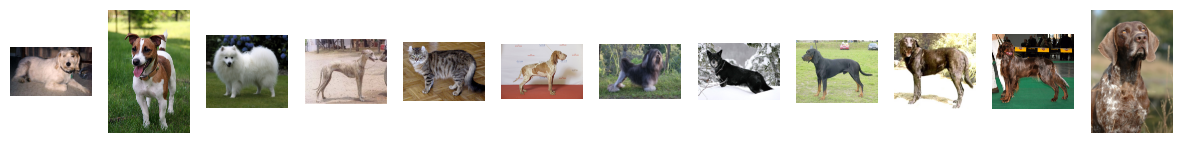

In [25]:
recommended_img = recommendations["nom_image"].tolist()

# Creatation d'une figure
fig, axes = plt.subplots(1, len(recommended_img), figsize=(15, 5))

if len(recommended_img) == 1:
    axes = [axes]

# Affichage de chaque image
for ax, path in zip(axes, recommended_img):
    img = mpimg.imread("images/" + path)
    ax.imshow(img)
    ax.axis('off')  

plt.show() 